In [1]:
using Pkg
Pkg.instantiate()

In [2]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using LinearAlgebra
using Random
using FFTW
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames
using Plots
default(grid=false, size=(900,300), label="", margin=10Plots.pt)

In [167]:
include("../helpers/polynomial.jl");
include("../helpers/utils.jl");
include("../helpers/data.jl");

In [4]:
import ReactiveMP.messageout

## Generate signal

In [6]:
# find order
seed = 42

delay_y, delay_u, delay_e = 3, 3, 3
order_h = delay_e + 1 # e_k, e_{k-1}, e_{k-2}
order_u = delay_u + 1 # u_k, u_{k-1}, u_{k-2}

full_order = delay_e + delay_y + delay_u + 1
Y = zeros(full_order, delay_y); Y[1:delay_y, 1:delay_y] = diageye(delay_y);
U = zeros(full_order, order_u); U[delay_y+1:delay_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-delay_e+1:full_order, order_h-delay_e+1:order_h] = diageye(delay_e);

poly_order = 1

options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)
syn_input, syn_noise, syn_output, η_true = generate_data(seed, ϕ, options, scale_coef=0.2);

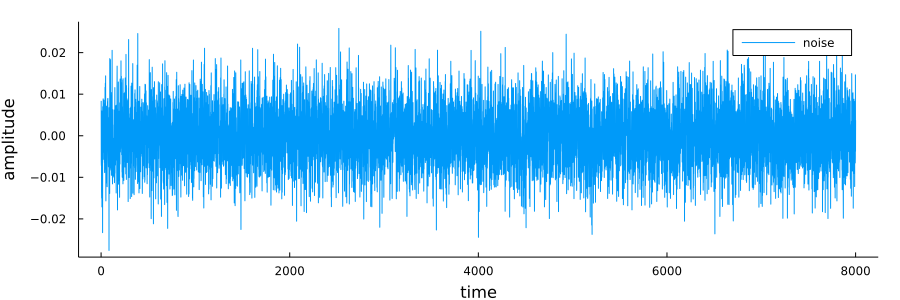

In [7]:
# Visualize noise
plot(syn_noise, xlabel="time", ylabel="amplitude", label="noise")

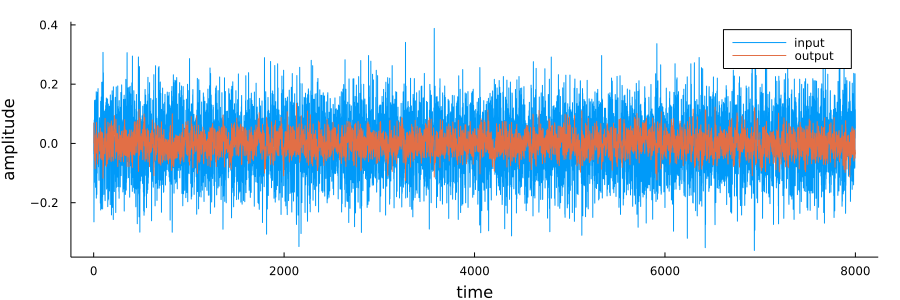

In [8]:
# Plot both input and outputs
plot(syn_input, label="input")
plot!(syn_output, xlabel="time", ylabel="amplitude", label="output")

In [9]:
train_size = 5000+order_u
test_size = 1000+order_u

u_train = syn_input[1:train_size]
u_val = syn_input[train_size + 1:train_size + test_size]
y_train = syn_output[1:train_size]
y_val = syn_output[train_size + 1:train_size + test_size]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = u_train
# input_val = u_val

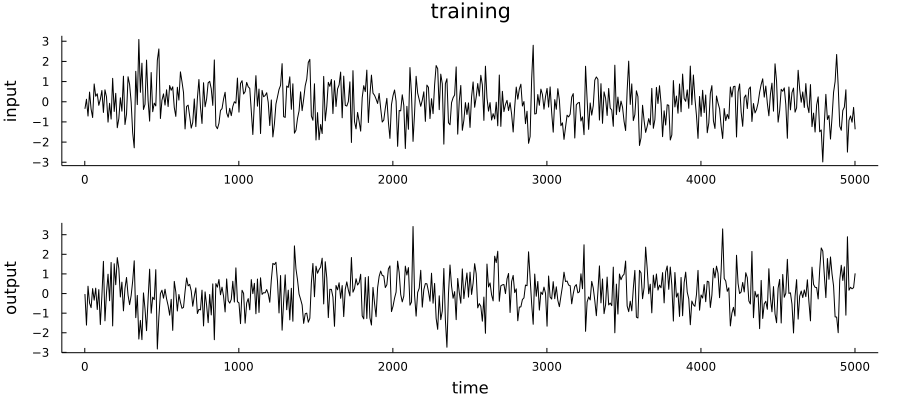

In [10]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

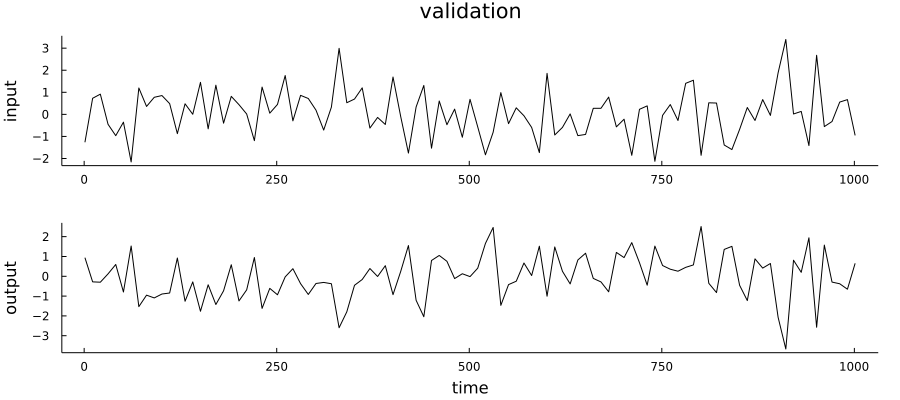

In [11]:
n = 10
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

## Model

In [137]:
# Nonlinear MAX model definition
@model function linear_max_mv(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_y, delay_u, delay_e)
    
    order = delay_y + delay_u + delay_e + 1
    order_h = delay_e + 1
        
    # initialize variables
    θ       = randomvar()
    w       = randomvar()
    h       = randomvar(n)
    uh      = randomvar(n)
    yuh     = randomvar(n)
    yuh_     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    Ys = [Y*y_prev[t] for t in 1:n]
    Us = [U*u[t] for t in 1:n]
    
    AR_meta_1 = ARMeta(Multivariate, order_h, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(order_h), diageye(order_h))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(order); b[1] = 1.0;
    c = zeros(order_h); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w)
        uh[t] ~ H*h[t] + Us[t]
        yuh[t] ~ uh[t] + Ys[t]
        yuh_[t] ~ AR(yuh[t], η, τ)

        y_nodes[t], y[t] ~ dot(yuh_[t], b) + dot(h[t], c)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, yuh_, y
end

In [138]:
# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size-order_u], observations[1:train_size-order_u], controls[1:train_size-order_u];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size-order_u], observations[1:test_size-order_u], controls[1:test_size-order_u];

In [139]:
@meta function armax_meta(artype, order_1, order_2, stype)
    AR(h, θ, w) -> ARMeta(artype, order_1, stype)
    AR(yuh_, η, τ) -> ARMeta(artype, order_2, stype)
end

armax_meta (generic function with 1 method)

In [142]:
armax_constraints = @constraints begin
    q(θ) :: Marginal(MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)))
    q(yuh_, yuh, η, τ, h_0, h, θ, w) = q(yuh_, yuh)q(η)q(τ)q(h_0, h)q(θ)q(w)
end

Constraints:
	marginals form:
		q(θ) :: FixedMarginalConstraint(MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0]
Λ: [1.0e12 0.0 0.0 0.0; 0.0 1.0e12 0.0 0.0; 0.0 0.0 1.0e12 0.0; 0.0 0.0 0.0 1.0e12]
)
) [ prod_constraint = ProdGeneric(ProdAnalytical()) ]
	messages form:
	factorisation:
		q(yuh_, yuh, η, τ, h_0, h, θ, w) = q(yuh_, yuh)q(η)q(τ)q(h_0, h)q(θ)q(w)


In [143]:
coefs_precision = diageye(full_order)
coefs_mean = 0.1*ones(full_order);
# coefs_mean = randn(full_order); 
# coefs_mean[end-delay_e+1:end] = zeros(delay_e)
# coefs_precision[end-delay_e+1:end,end-delay_e+1:end] = 1e5*diageye(delay_e)
# coefs_precision[1:3, 1:3] = 1e3*diageye(3)
# coefs_precision[4:7, 4:7] = 1e-10*diageye(4)
# coefs_precision[7:end, 7:end] = 1e3*diageye(4)

In [144]:
h_prior, w_prior, η_prior, τ_prior = MvNormalMeanPrecision(zeros(order_h), diageye(order_h)), GammaShapeRate(1e4, 1.0), MvNormalMeanPrecision(coefs_mean, coefs_precision),  GammaShapeRate(1e2, 1.0)

(MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0]
Λ: [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
)
, GammaShapeRate{Float64}(a=10000.0, b=1.0), MvNormalMeanPrecision(
μ: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Λ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)
, GammaShapeRate{Float64}(a=100.0, b=1.0))

In [145]:
armax_imarginals = (h = h_prior,
                    w = w_prior,
                    θ = MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)),
                    τ = τ_prior,
                    η = η_prior);

In [146]:
armax_imessages = (h = MvNormalMeanPrecision(zeros(order_h), diageye(order_h)), );

In [147]:
armax_model = Model(linear_max_mv, length(Y_train), 
                    (mean(h_prior), precision(h_prior)), 
                    (shape(w_prior), rate(w_prior)), 
                    (mean(η_prior), precision(η_prior)), 
                    (shape(τ_prior), rate(τ_prior)), 
                    X_train, U_train, delay_y, delay_u, delay_e);

In [148]:
# First execution is slow due to Julia's initθmpilation 
result = inference(
    model = armax_model, 
    data  = (y = Y_train, ),
    constraints   = armax_constraints,
    meta          = armax_meta(Multivariate, order_h, full_order, ARsafe()),
    options       = model_options(limit_stack_depth = 500),
    initmarginals = armax_imarginals,
    initmessages  = armax_imessages,
    returnvars    = (θ = KeepLast(), w=KeepLast(), h=KeepLast(), η=KeepLast(), τ=KeepLast(), yuh_=KeepLast()),
    free_energy   = true,
    iterations    = 100, 
    showprogress  = true
);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


In [149]:
fe = result.free_energy

100-element Vector{Real}:
  -8350.178022572305
 -14565.951958620804
  -8570.72411291243
 -10715.147696476663
 -11791.08987221052
 -12731.658234885894
 -13405.092567943735
 -13980.29109667777
 -14470.071602303535
 -14896.898351692013
 -15273.272274142946
 -15610.698513103998
 -15916.259359445423
      ⋮
 -20687.468249691767
 -20691.186206862098
 -20694.316421905765
 -20698.226126142778
 -20701.56177669682
 -20704.647036042297
 -20706.837359792553
 -20709.56285538827
 -20711.45355875697
 -20714.41192126472
 -20715.9521677203
 -20717.666626994964

In [150]:
using Parameters
@unpack θ, w, h, η, τ, yuh_ = result.posteriors

Dict{Symbol, Any} with 6 entries:
  :w    => Marginal(GammaShapeRate{Float64}(a=12500.0, b=1.2554820294407536))
  :τ    => Marginal(GammaShapeRate{Float64}(a=2600.0, b=20.8521465023279))
  :yuh_ => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :h    => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :θ    => Marginal(MvNormalMeanPrecision(…
  :η    => Marginal(MvNormalWeightedMeanPrecision(…

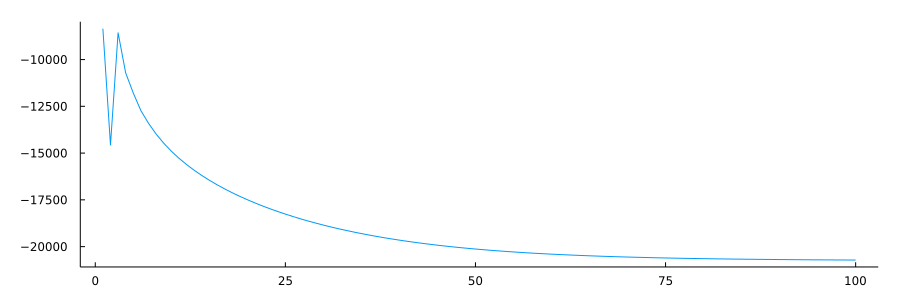

In [152]:
plot(fe)

In [153]:
# note y_out != yuh_, yuh_ is output of AR solely
y_out_ = yuh_;

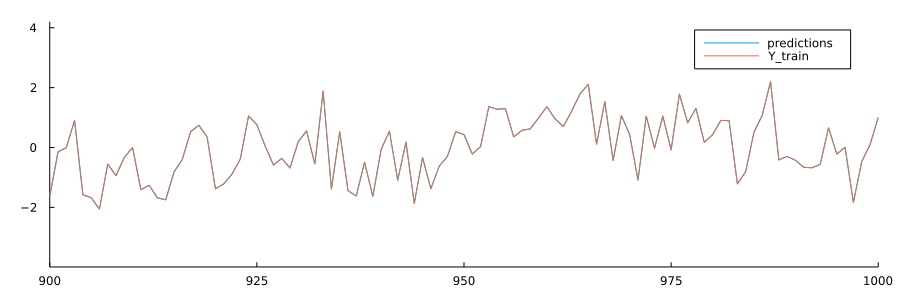

In [154]:
mfrom, mto = 900, 1000
plot(first.(mean.(y_out_)), ribbon=first.(sqrt.(cov.(y_out_))), label="predictions")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

In [155]:
mean(w)

9956.335261579208

In [156]:
mean(τ)

124.68740327091697

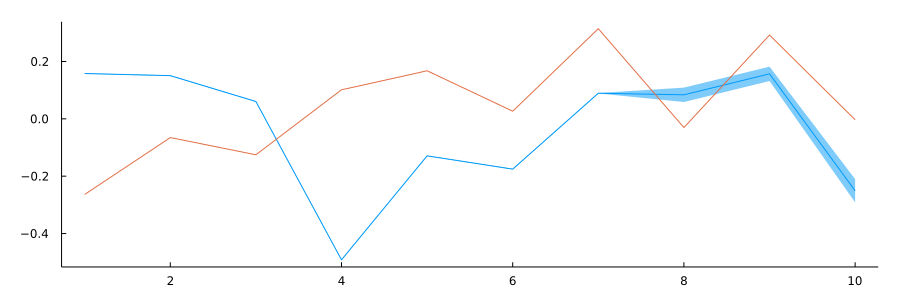

In [157]:
plot(mean(η), ribbon=diag(std(η)), label=false)
plot!(η_true, label=false)

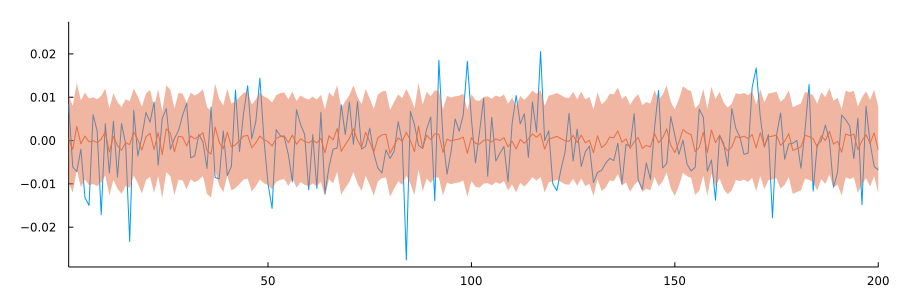

In [158]:
plot(syn_noise)
plot!(first.(mean.(h)), ribbon=sqrt.(first.(cov.(h))), xlims=(1, 200))

## Prediction

In [159]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [168]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(w_mle, order_h)))
    Ys = Y*y_prev
    Us = U*u
    h_ = @call_rule typeof(*)(:out, Marginalisation) (m_A=PointMass(H), m_in=h_out)
    uh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Us), m_in2=h_)
    yuh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Ys), m_in2=uh)
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=yuh, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)
end

prediction (generic function with 1 method)

In [161]:
function inference_callback(h_prior, η_prior, τ_prior, w_prior, Y, X, U, delay_y, delay_u, delay_e)
    
    armax_imarginals = (h = h_prior,
                        w = w_prior,
                        θ = MvNormalMeanPrecision(zeros(delay_e+1), 1e12*diageye(delay_e+1)),
                        τ = τ_prior,
                        η = η_prior);
    
    armax_imessages = (h = MvNormalMeanPrecision(zeros(delay_e+1), diageye(delay_e+1)), );
    
    armax_model = Model(linear_max_mv, length(Y), (mean(h_prior), precision(h_prior)), (shape(w_prior), rate(w_prior)), (mean(η_prior), precision(η_prior)), (shape(τ_prior), rate(τ_prior)), X, U, delay_y, delay_u, delay_e);
    
    armax_imarginals = (h = h_prior,
                        w = w_prior,
                        θ = MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)),
                        τ = τ_prior,
                        η = η_prior);
    
    full_order = delay_y + delay_u + delay_e
    res = inference(
        model = armax_model, 
        data  = (y = Y, ),
        constraints   = armax_constraints,
        meta          = armax_meta(Multivariate, delay_e+1, full_order, ARsafe()),
        options       = model_options(limit_stack_depth = 500),
        initmarginals = armax_imarginals,
        initmessages  = armax_imessages,
        returnvars    = (θ = KeepLast(), w=KeepLast(), h=KeepLast(), η=KeepLast(), τ=KeepLast(), yuh_=KeepLast()),
        free_energy   = true,
        iterations    = 10, 
        showprogress  = true)

    @unpack θ, w, h, η, τ, yuh_ = res.posteriors
    θ.data, w.data, h[end].data, η.data, τ.data
end

inference_callback (generic function with 1 method)

In [163]:
predictions = []
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_prior), η_prior, τ_prior, X_test[i], U_test[i], full_order=full_order, h_order=order_h)
    push!(predictions, pred)
    θ_post, w_post, h_post, η_post, τ_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, [Y_test[i]], [X_test[i]], [U_test[i]], delay_y, delay_u, delay_e)
    h_prior = h_post
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
end

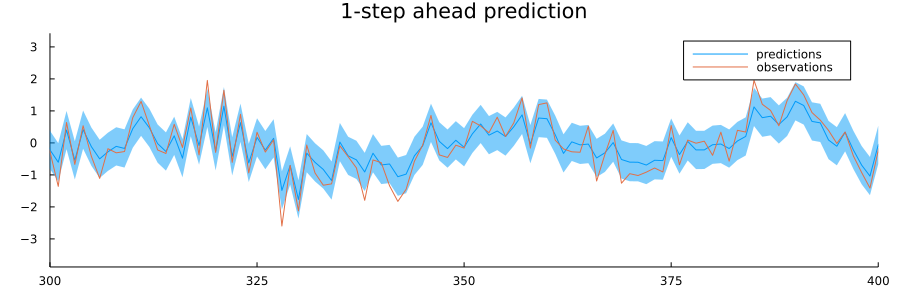

In [164]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(300, 400), title="1-step ahead prediction", label="observations")

In [165]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.4084746036687206

In [99]:
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
simulated_error = Vector{Any}([h[end]])

ProgressMeter.@showprogress for i in 1:length(Y_test)
    θ_post, w_post, h_post, η_post, τ_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, [simulated_Y[i]], [simulated_X[i]], [U_test[i]], delay_y, delay_u, delay_e)
    
    h_prior = h_post
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
    
    push!(simulated_X, [simulated_Y[i]; simulated_X[i][1:delay_y-1]])
    
    pred_sim = prediction(h_prior, mean(w_prior), η_prior, τ_prior, simulated_X[end], U_test[i], full_order=full_order, h_order=order_h)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))
    push!(simulated_error, h_prior)
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [169]:
zoom = 900:1000
RMSE = sqrt(mean((simulated_Y[zoom .+ 1] .- Y_test[zoom]).^2))

0.5462060894595505

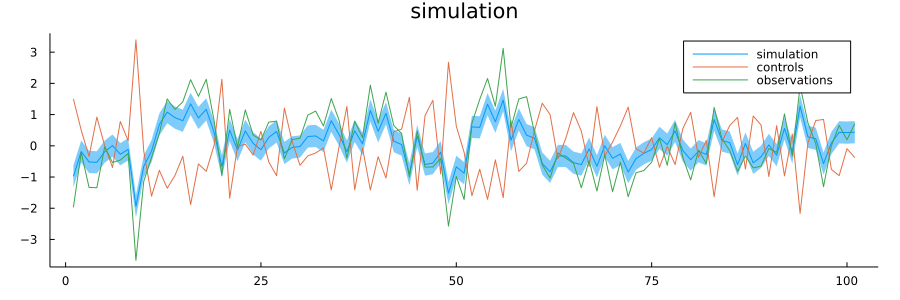

In [170]:
plot(simulated_Y[zoom.+1],  ribbon=simulated_Y_cov[zoom], label="simulation")
plot!(first.(U_test[zoom]), label="controls")
plot!(Y_test[zoom], title="simulation", label="observations")